In [43]:
# Cell 1: Setup
import data_loader
import importlib
importlib.reload(data_loader)

print(f"Box size1: {BOX_SIZE}")

# Setup
from data_loader import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

print("BOX_SIZE2:", BOX_SIZE)


Loading bubble data...
✓ Loaded 634277 observations
✓ Timesteps added: 0 to 3426
✓ Identified 300 disappearing bubbles
Applying periodic boundary corrections...
✓ Periodic boundary correction applied
✓ Derived quantities computed

DATA LOADING COMPLETE
Total observations:       634,277
Unique bubbles:           400
Timesteps:                0 to 3426
Disappearing bubbles:     300
Box size:                 22.36068
Initial avg area (A_0):   1.000000

Available variables:
  - df: Original dataframe
  - df_corrected: Corrected dataframe with actual_area column
  - disappearing_ids: Set of disappearing bubble IDs
  - bubbles_per_timestep: Number of bubbles at each timestep
  - avg_area_per_timestep: Average bubble area at each timestep
  - approx_avg_area: Approximate area from liquid fraction
  - A_0: Initial average bubble area
  - max_timestep: Maximum timestep
  - final_step: Final timestep
  - box_area: Total box area
  - BOX_SIZE, PERIODIC_THRESHOLD, LIQUID_FRACTION: Constants

Box s

In [51]:
print(BOX_SIZE) 

def per_step_displacements(df_corrected: pd.DataFrame, dt: int = 1) -> pd.DataFrame:
    """
    Compute consecutive-step displacements for each track id.
    Returns one row per valid step (from timestep t to t+dt).
    Columns:
      id, t_start, t_end, dx, dy, step, step2, area_start, area_end, area_mean
    """
    cols_needed = {"id", "timestep", "x", "y"}
    if not cols_needed.issubset(df_corrected.columns):
        raise ValueError(f"DataFrame must contain {cols_needed}")

    g = df_corrected.sort_values(["id", "timestep"]).copy()

    # Shift within each id
    g["x_next"] = g.groupby("id")["x"].shift(-dt)
    g["y_next"] = g.groupby("id")["y"].shift(-dt)
    g["t_next"] = g.groupby("id")["timestep"].shift(-dt)
    
    # Displacements
    g["dx"] = g["x_next"] - g["x"]
    g["dy"] = g["y_next"] - g["y"]
    g["step2"] = g["dx"]**2 + g["dy"]**2
    g["step"]  = np.sqrt(g["step2"])
    
    # Coarsening proxy via area (optional)
    if "area" in g.columns:
        g["area_start"] = g["area"]
        g["area_end"]   = g.groupby("id")["area"].shift(-dt)
        g["area_mean"]  = (g["area_start"] + g["area_end"]) / 2.0
    else:
        g["area_start"] = np.nan
        g["area_end"]   = np.nan
        g["area_mean"]  = np.nan
    
    out = g.dropna(subset=["x_next", "y_next", "t_next"]).copy()
    out = out.rename(columns={"timestep":"t_start", "t_next":"t_end"})
    return out[["id","t_start","t_end","dx","dy","step","step2","area_start","area_end","area_mean"]]

steps = per_step_displacements(df_corrected, dt=1)
steps.head()
print(steps)

22.36068
        id  t_start  t_end        dx        dy      step         step2  \
0        1        0    1.0 -0.000002 -0.000302  0.000302  9.120800e-08   
400      1        1    2.0 -0.000033 -0.000413  0.000414  1.716580e-07   
800      1        2    3.0 -0.000051 -0.000506  0.000509  2.586370e-07   
1200     1        3    4.0 -0.000086 -0.000545  0.000552  3.044210e-07   
1600     1        4    5.0 -0.000127 -0.000556  0.000570  3.252650e-07   
...    ...      ...    ...       ...       ...       ...           ...   
61622  400      162  163.0  0.000770 -0.004908  0.004968  2.468136e-05   
61971  400      163  164.0  0.000788 -0.005765  0.005819  3.385617e-05   
62320  400      164  165.0  0.006915 -0.015867  0.017308  2.995789e-04   
62669  400      165  166.0  0.000978 -0.006073  0.006151  3.783781e-05   
63017  400      166  167.0  0.001066 -0.008092  0.008162  6.661682e-05   

       area_start  area_end  area_mean  
0        1.502469  1.503002   1.502736  
400      1.503002  1

In [45]:
summary_by_time = (
    steps.groupby("t_start")
         .agg(n=("step2","size"),
              mean_step2=("step2","mean"),
              median_step2=("step2","median"),
              std_step2=("step2","std"),
              mean_step=("step","mean"),
              median_step=("step","median"))
         .reset_index()
) # Compute summary statistics per timestep

# Standard error for the mean (useful error bars)
summary_by_time["sem_step2"] = summary_by_time["std_step2"] / np.sqrt(summary_by_time["n"])
summary_by_time.head()

,t_start,n,mean_step2,median_step2,std_step2,mean_step,median_step,sem_step2
0,0,400,4.220272e-07,1.476395e-07,7.306064e-07,0.000507,0.000384,3.653032e-08
1,1,400,6.248947e-07,2.214855e-07,1.097412e-06,0.000616,0.000471,5.487058e-08
2,2,400,9.317816e-07,3.256590e-07,1.635513e-06,0.000754,0.000571,8.177563e-08
3,3,400,1.042754e-06,3.901230e-07,1.829475e-06,0.000799,0.000625,9.147377e-08
4,4,400,9.903778e-07,3.737550e-07,1.762766e-06,0.000776,0.000611,8.813831e-08


0.50701476


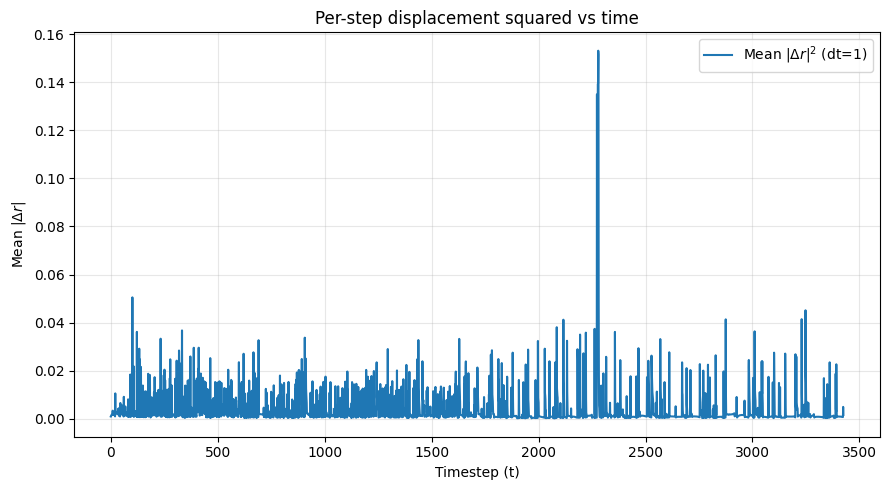

Got 400 bubbles' first steps
[3.02006622e-04 8.50440474e-04 5.03572239e-04 5.37077276e-04
 1.45915215e-03 4.88380999e-04 6.92290401e-04 3.55879193e-04
 1.45351608e-03 7.96115569e-04 1.49560590e-03 4.81000000e-04
 2.13883146e-04 1.95649738e-03 2.66790180e-04 1.03000000e-04
 3.73048254e-04 3.71618084e-05 1.43280006e-03 3.11717821e-04
 7.63929971e-04 5.40715267e-04 1.55630974e-04 1.90000000e-05
 1.44890717e-03 2.64781042e-04 4.98775501e-04 1.88767052e-04
 1.00224747e-04 2.75771645e-04 8.02030548e-04 4.36056189e-04
 2.49927990e-04 2.45538184e-04 1.51462867e-04 4.95795321e-04
 2.52301407e-04 2.42076434e-04 2.76028984e-04 6.93862378e-04
 5.67651301e-04 4.79766610e-04 2.51813423e-04 3.45000000e-04
 9.14822387e-05 2.07663189e-04 2.12903734e-04 4.13483978e-04
 3.34073345e-04 4.73431093e-04 1.46563979e-04 5.64415627e-04
 5.07550983e-04 1.09696490e-03 3.57917588e-04 2.73437379e-04
 7.42970390e-04 2.03806281e-04 3.22024844e-05 2.01791972e-04
 2.58862898e-04 5.42647215e-04 2.27407124e-04 2.22970850

In [46]:
# divide by the initial bubble diameter
initial_averagediam = df_corrected[df_corrected["timestep"]==0]["area"].mean()
print(initial_averagediam)

# Plot mean per-step squared displacement vs time
plt.figure(figsize=(9,5))
plt.plot(summary_by_time["t_start"], (summary_by_time["mean_step"]/(initial_averagediam)), label=r"Mean $|\Delta r|^2$ (dt=1)")
plt.xlabel("Timestep (t)")
plt.ylabel(r"Mean $|\Delta r|$")
plt.title("Per-step displacement squared vs time")
plt.legend()
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

# print out 400 values of first step
first_steps = steps[steps["t_start"] == 0]["step"].values
print(f"Got {len(first_steps)} bubbles' first steps")
print(first_steps)



0.50701476
[5.95656471e-04 1.67734855e-03 9.93210216e-04 1.05929318e-03
 2.87792835e-03 9.63248089e-04 1.36542455e-03 7.01910913e-04
 2.86681216e-03 1.57020196e-03 2.94982714e-03 9.48690330e-04
 4.21847967e-04 3.85885685e-03 5.26198053e-04 2.03149904e-04
 7.35773953e-04 7.32953186e-05 2.82595334e-03 6.14810151e-04
 1.50672136e-03 1.06646849e-03 3.06955509e-04 3.74742542e-05
 2.85772188e-03 5.22235372e-04 9.83749468e-04 3.72310763e-04
 1.97676193e-04 5.43912459e-04 1.58186824e-03 8.60046341e-04
 4.92940264e-04 4.84282123e-04 2.98734630e-04 9.77871573e-04
 4.97621424e-04 4.77454412e-04 5.44420016e-04 1.36852501e-03
 1.11959522e-03 9.46257679e-04 4.96658959e-04 6.80453563e-04
 1.80433088e-04 4.09580165e-04 4.19916245e-04 8.15526510e-04
 6.58902603e-04 9.33761954e-04 2.89072411e-04 1.11321340e-03
 1.00105761e-03 2.16357588e-03 7.05931299e-04 5.39308518e-04
 1.46538217e-03 4.01973072e-04 6.35138992e-05 3.98000193e-04
 5.10562845e-04 1.07027893e-03 4.48521704e-04 4.39771911e-04
 2.22488871e-

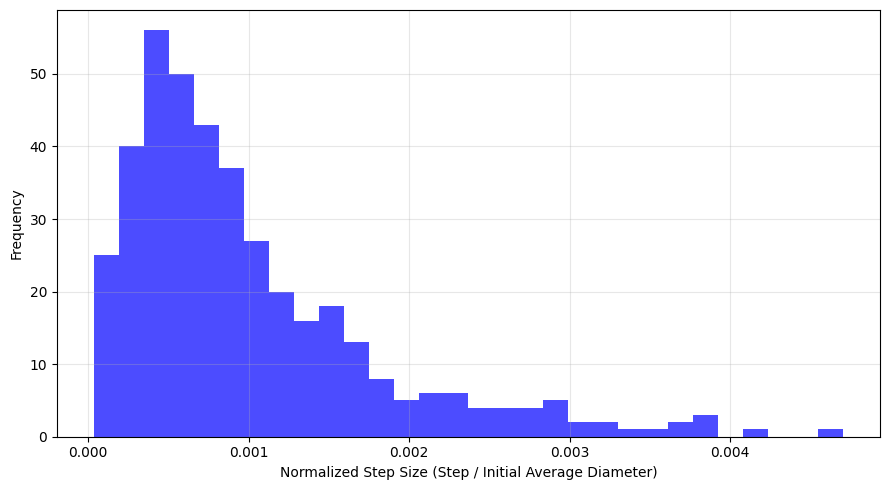

In [47]:

# divide by the initial bubble diameter
initial_averagediam = df_corrected[df_corrected["timestep"]==0]["area"].mean()
print(initial_averagediam)

#divide first 400 steps by initial average diameter
normalized_steps = first_steps / initial_averagediam
print(normalized_steps)

# create a histogram of the normalized steps
plt.figure(figsize=(9,5))
plt.hist(normalized_steps, bins=30, alpha=0.7, color='blue')
plt.xlabel("Normalized Step Size (Step / Initial Average Diameter)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Plotting 35 timesteps: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400]
Creating 12x3 grid


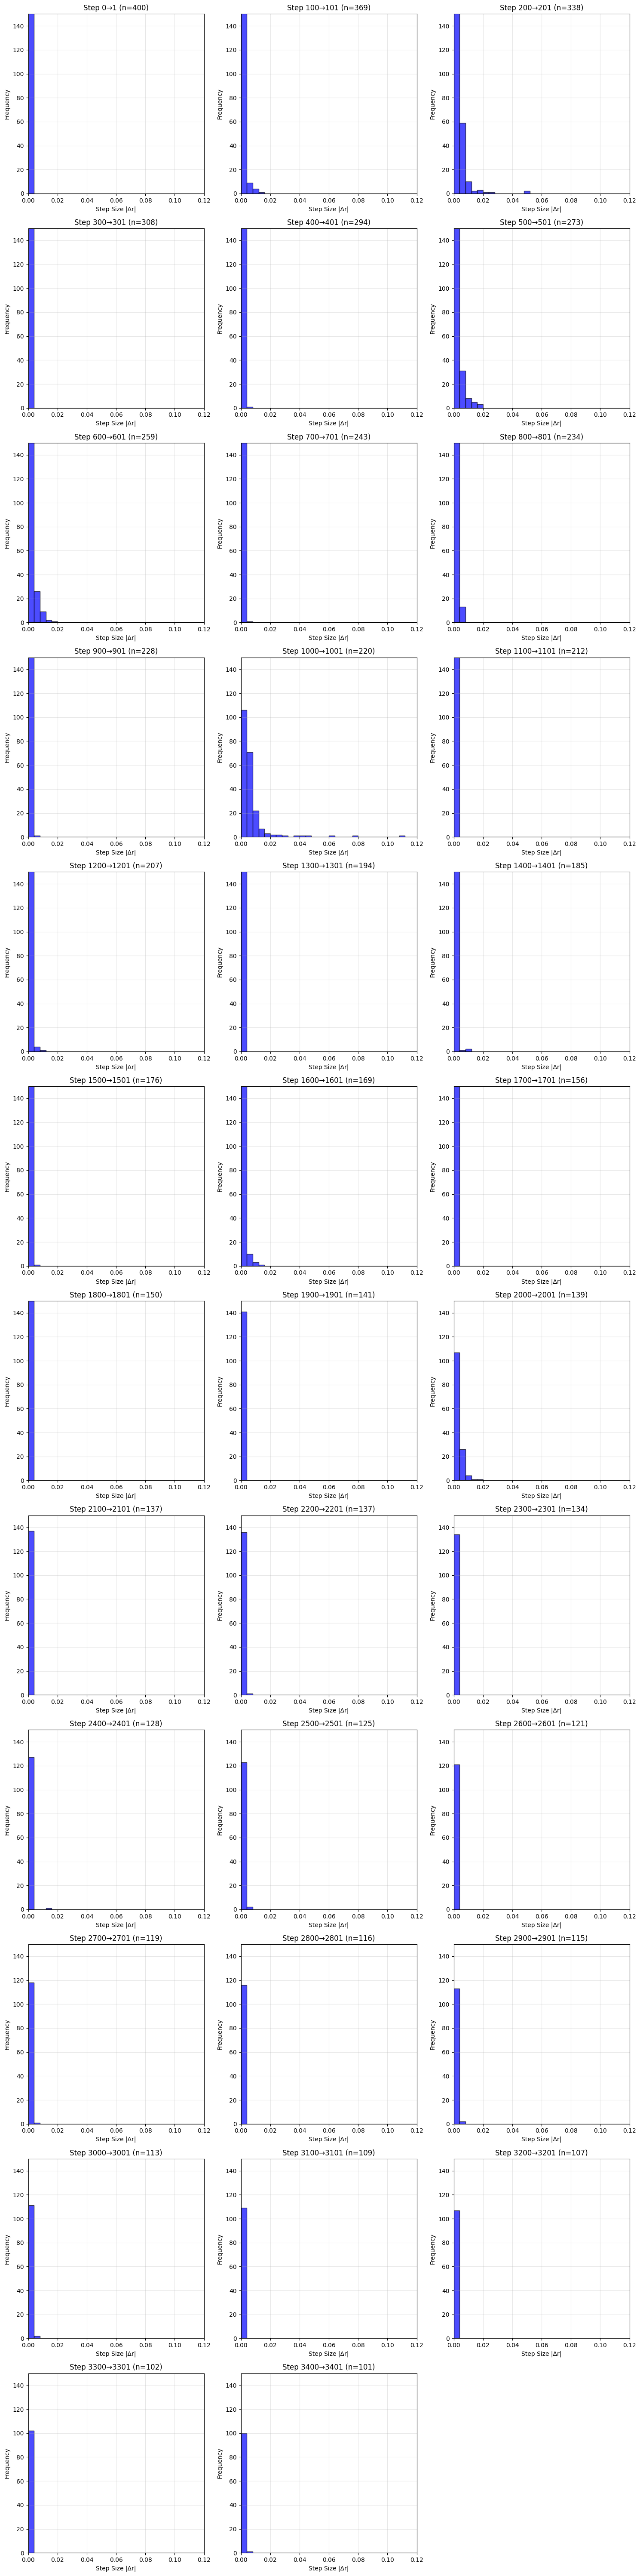

In [48]:
# Get steps at regular intervals (every 100th step)
max_timestep = steps["t_start"].max()
step_interval = 100
timesteps_to_plot = list(range(0, max_timestep + 1, step_interval))

print(f"Plotting {len(timesteps_to_plot)} timesteps: {timesteps_to_plot}")

# Calculate grid size dynamically
n_plots = len(timesteps_to_plot)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

print(f"Creating {n_rows}x{n_cols} grid")

# Plot histograms
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.ravel()

for idx, t in enumerate(timesteps_to_plot):
    step_data = steps[steps["t_start"] == t]["step"].values
    
    if len(step_data) > 0:
        # Use range=(0, 0.12) to force consistent bin edges
        axes[idx].hist(step_data, bins=30, range=(0, 0.12), 
                      alpha=0.7, color='blue', edgecolor='black')
        axes[idx].set_title(f"Step {t}→{t+1} (n={len(step_data)})")
        axes[idx].set_xlabel("Step Size |Δr|")
        axes[idx].set_ylabel("Frequency")
        axes[idx].grid(alpha=0.3)
        axes[idx].set_xlim(0, 0.12)
        axes[idx].set_ylim(0, 150)
    else:
        axes[idx].text(0.5, 0.5, f'No data at t={t}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"Step {t}→{t+1}")

# Remove empty subplots if any
for idx in range(n_plots, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

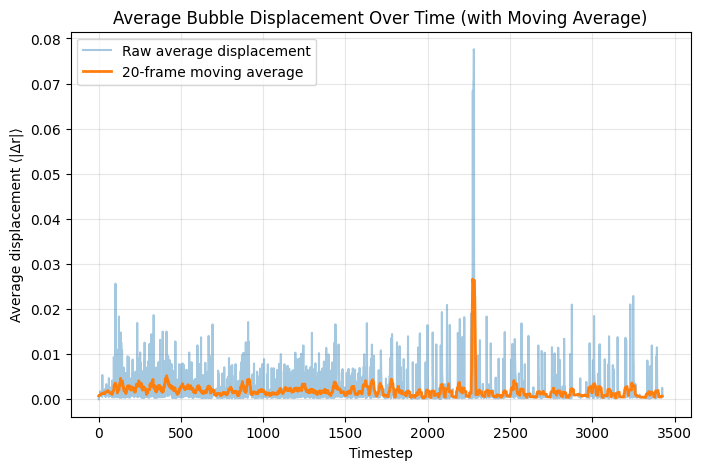

In [49]:

# Sort for safety
df_corrected = df_corrected.sort_values(["id", "timestep"])

# Compute per-bubble step displacement
df_corrected["disp_mag"] = (
    df_corrected.groupby("id")[["x", "y"]]
    .diff()
    .pow(2)
    .sum(axis=1)
    .pow(0.5)
)

avg_disp_per_timestep = (
    df_corrected.groupby("timestep")["disp_mag"]
    .mean()
    .reset_index(name="avg_disp")
)

window = 20

avg_disp_per_timestep["avg_disp_smooth"] = (
    avg_disp_per_timestep["avg_disp"]
    .rolling(window=window, min_periods=1, center=True)
    .mean()
)


plt.figure(figsize=(8, 5))
plt.plot(avg_disp_per_timestep["timestep"], avg_disp_per_timestep["avg_disp"], label="Raw average displacement", alpha=0.4)
plt.plot(avg_disp_per_timestep["timestep"], avg_disp_per_timestep["avg_disp_smooth"], label=f"{window}-frame moving average", linewidth=2)
plt.xlabel("Timestep")
plt.ylabel("Average displacement ⟨|Δr|⟩")
plt.title("Average Bubble Displacement Over Time (with Moving Average)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()